In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
import warnings
warnings.filterwarnings("ignore")

df = pd.read_csv('delhivery_data.csv')

#converting time column to date time.
df['od_start_time'] = pd.to_datetime(df['od_start_time'], errors='coerce')
df['od_end_time'] = pd.to_datetime(df['od_end_time'], errors='coerce')

#drop rows with missing critical values.
df = df.dropna(subset=['segment_actual_time', 'segment_osrm_time', 'actual_distance_to_destination', 'factor'])

#calculating delay
df['delay_minutes'] = df['segment_actual_time'] - df['segment_osrm_time']
df['is_delayed'] = (df['delay_minutes'] > 15).astype(int)
print(df)

            data          trip_creation_time  \
0       training  2018-09-20 02:35:36.476840   
1       training  2018-09-20 02:35:36.476840   
2       training  2018-09-20 02:35:36.476840   
3       training  2018-09-20 02:35:36.476840   
4       training  2018-09-20 02:35:36.476840   
...          ...                         ...   
144862  training  2018-09-20 16:24:28.436231   
144863  training  2018-09-20 16:24:28.436231   
144864  training  2018-09-20 16:24:28.436231   
144865  training  2018-09-20 16:24:28.436231   
144866  training  2018-09-20 16:24:28.436231   

                                      route_schedule_uuid route_type  \
0       thanos::sroute:eb7bfc78-b351-4c0e-a951-fa3d5c3...    Carting   
1       thanos::sroute:eb7bfc78-b351-4c0e-a951-fa3d5c3...    Carting   
2       thanos::sroute:eb7bfc78-b351-4c0e-a951-fa3d5c3...    Carting   
3       thanos::sroute:eb7bfc78-b351-4c0e-a951-fa3d5c3...    Carting   
4       thanos::sroute:eb7bfc78-b351-4c0e-a951-fa3d5c3...    Ca

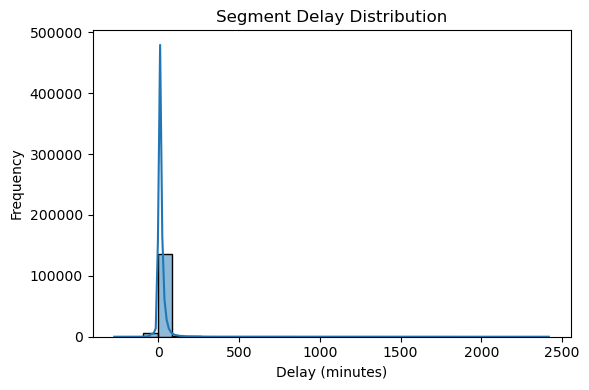

In [2]:
plt.figure(figsize=(6, 4))
sns.histplot(df['delay_minutes'], bins=30, kde=True)
plt.title('Segment Delay Distribution')
plt.xlabel('Delay (minutes)')
plt.ylabel('Frequency')
plt.tight_layout()
plt.show()
plt.savefig('delay_distribution.png')
plt.close()

In [3]:
x = df[['route_type', 'source_name', 'destination_name', 'actual_distance_to_destination', 'factor']] #x is independent variable.
y = df['is_delayed'] #y is dependent variable.
categorical_cols = ['route_type', 'source_name', 'destination_name'] #categorical columns.
numerical_cols = ['actual_distance_to_destination', 'factor'] #numerical columns.

preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(drop='first', handle_unknown='ignore'), categorical_cols),
        ('num', 'passthrough', numerical_cols)
    ]
)

pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(n_estimators=100, random_state=42))
])
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42) #splitting train and test.
pipeline.fit(x_train, y_train) #training the model.
y_pred = pipeline.predict(x_test) #predicting and evaluating.
print("\nClassification Report:")
print(classification_report(y_test, y_pred))


Classification Report:
              precision    recall  f1-score   support

           0       0.84      0.88      0.86     19398
           1       0.74      0.65      0.69      9576

    accuracy                           0.81     28974
   macro avg       0.79      0.77      0.78     28974
weighted avg       0.80      0.81      0.81     28974



In [4]:
print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))


Confusion Matrix:
[[17144  2254]
 [ 3304  6272]]


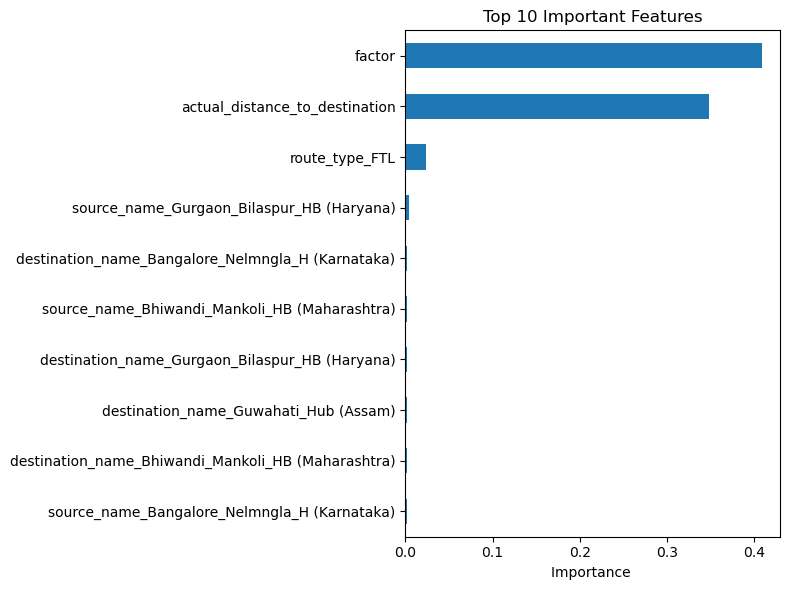

In [7]:
a = pipeline.named_steps['preprocessor'].named_transformers_['cat']
encoded_feature_names = a.get_feature_names_out(categorical_cols)
feature_names = list(encoded_feature_names) + numerical_cols
importances = pd.Series(pipeline.named_steps['classifier'].feature_importances_, index=feature_names) #it gives top 10 feature which is important in case of delay.

#ploting 10 features that will influence the delay.
plt.figure(figsize=(8, 6))
importances.nlargest(10).sort_values().plot(kind='barh')
plt.title('Top 10 Important Features')
plt.xlabel('Importance ')
plt.tight_layout()
plt.show()
plt.savefig('feature_importance.png')
plt.close()